In [1]:
import os

import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Activation,
    Conv2D,
    BatchNormalization,
    AveragePooling2D,
    Flatten,
    Lambda,
    add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    ReduceLROnPlateau
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import MSE, BinaryCrossentropy
from tensorflow.keras import backend as K

from utils import config_gpu
_ = config_gpu()

/home/youjin2/venvs/py3/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## introduction
- VAE (Variational Autoencoder) is a generative model like GAN
- But,
    - GAN focuces on the model which approximates input data distribution
    - VAE focuces on the model which can decode input data distribution on the continuous latent space
    
- VAE vs Autoencoder
    - They both learn a latent-space and try to reconstruct the input data distribution|
    - But, VAE's latent-space is continuous and decoder is used as a generative model

## notations

* $x \sim P_\theta (x)$
    - real data distribution
    - $\theta$: parameter to be learned
        - e.g.
            - face
            - hand-written number
            
* $P_\theta (x, z)$
    - join distribution of input $x$ and latent variable $z$
    - not a part of input data, but encode observable features from input data
        - e.g.
            - face data: facial expression, hair shape, hair color, sex, $\cdots$
            - mnist: number, hand-writting

## Variational Inference
* $P_\theta (x) = \int P_\theta (x, z) dz$
    - **usually intractable!**
    - Note that
\begin{align*}
P_\theta (x) &= \int P_\theta (x, z) dz \\
&= \int P_\theta (x|z) P(z) dz \quad \quad \quad \quad (1)\\
&= \int P_\theta (z|x) P(x) dz \quad \quad \quad \quad (2)\\
\end{align*}
        - (1) is inappropriate since it does not give any restrictions on $z$
        - (2) is also hard to solve
        - So, VAE aims to approximate **$P_\theta(z|x)$** while finding tractable conditional distribution (see below)

* $Q_\phi (z|x) \approx P_\theta (z|x)$
    - $Q_\phi (z|x)$ is usuaully multivariate gaussian 
    $$Q_\phi (z|x) = N(z; \mu (x), diag(\sigma (x)))$$
    
* How to measure the distance between $Q_\phi(z|x)$ and $P_\theta(z|x)$?
* $D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log Q_\phi(z|x) - log P_\theta (z|x) \big]$
    - $Q_\phi(z|x)$: generates $z$ from input $x$
    - $P_\theta(x|z)$: reconstruct $x$ from latent $z$
        - similiar to decoder in autoencoder

* Plugin $P_\theta (z|x) = \frac{P_\theta(x|z) P_\theta (z)}{P_\theta(x)}$ gives
    - $D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log Q_\phi(z|x) - log P_\theta (x|z) - log P_\theta (z)\big] + log P_\theta (x)$
    
* Re-arranging above equation gives
$$log P_\theta (x) - D_{KL}(Q_\phi(z|x) || P_\theta(z|x)) = E_{z\sim Q} \big[log P_\theta (x|z) - D_{KL} (Q_\phi (z|x) || P_\theta(z))\big]$$
    - LHS is called **variational lower bound** OR **ELBO (evidence lower bound)**

In [2]:
def sampling(args):
    z_mean, z_log_var = args
    
    batch = K.shape(z_mean)[0]    
    dim = K.int_shape(z_mean)[1]
    
    # sample from N(0, I)
    epsilon = K.random_normal(shape=(batch, dim))
    
    return z_mean + K.exp(0.5*z_log_var)*epsilon

## load mnist

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
img_size = x_train.shape[1]
original_dim = img_size*img_size

In [5]:
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

## network parameter

In [6]:
input_shape = (original_dim, )
intermidate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

## build encoder

In [7]:
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermidate_dim, activation='relu')(inputs)

In [8]:
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

In [9]:
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

In [10]:
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

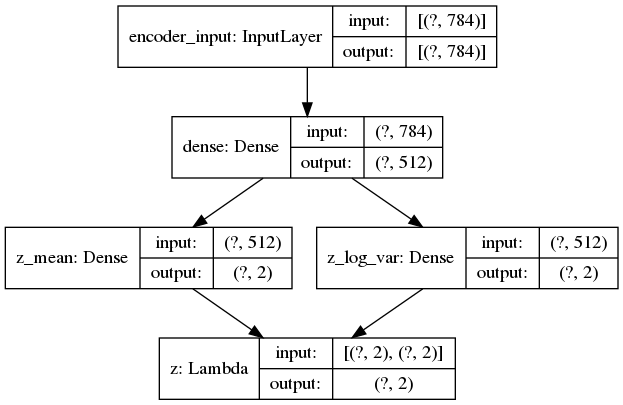

In [11]:
plot_model(encoder, to_file='../figures/vae_mlp_encoder.png', show_shapes=True)

## build decoder

In [12]:
latent_inputs = Input(shape=(latent_dim, ), name='z_sampling')

In [13]:
x = Dense(intermidate_dim, activation='relu')(latent_inputs)

In [14]:
outputs = Dense(original_dim, activation='sigmoid')(x)

In [15]:
decoder = Model(latent_inputs, outputs, name='decoder')

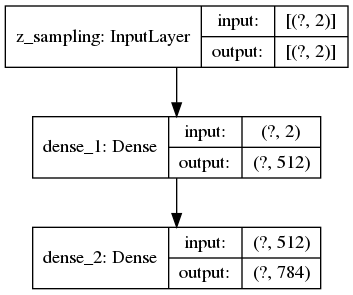

In [16]:
plot_model(decoder, to_file='../figures/vae_mlp_decoder.png', show_shapes=True)

## model instance

In [17]:
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

## define loss function

In [18]:
reconstruction_loss = MSE(inputs, outputs)
reconstruction_loss *= original_dim

In [19]:
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

In [20]:
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [21]:
vae.add_loss(vae_loss)

In [22]:
vae.compile(optimizer='adam')

In [23]:
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 784)]        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 2), (None, 2 403972      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Model)                 (None, 784)          403728      encoder[1][2]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          401920      encoder_input[0][0]              
____________________________________________________________________________________________

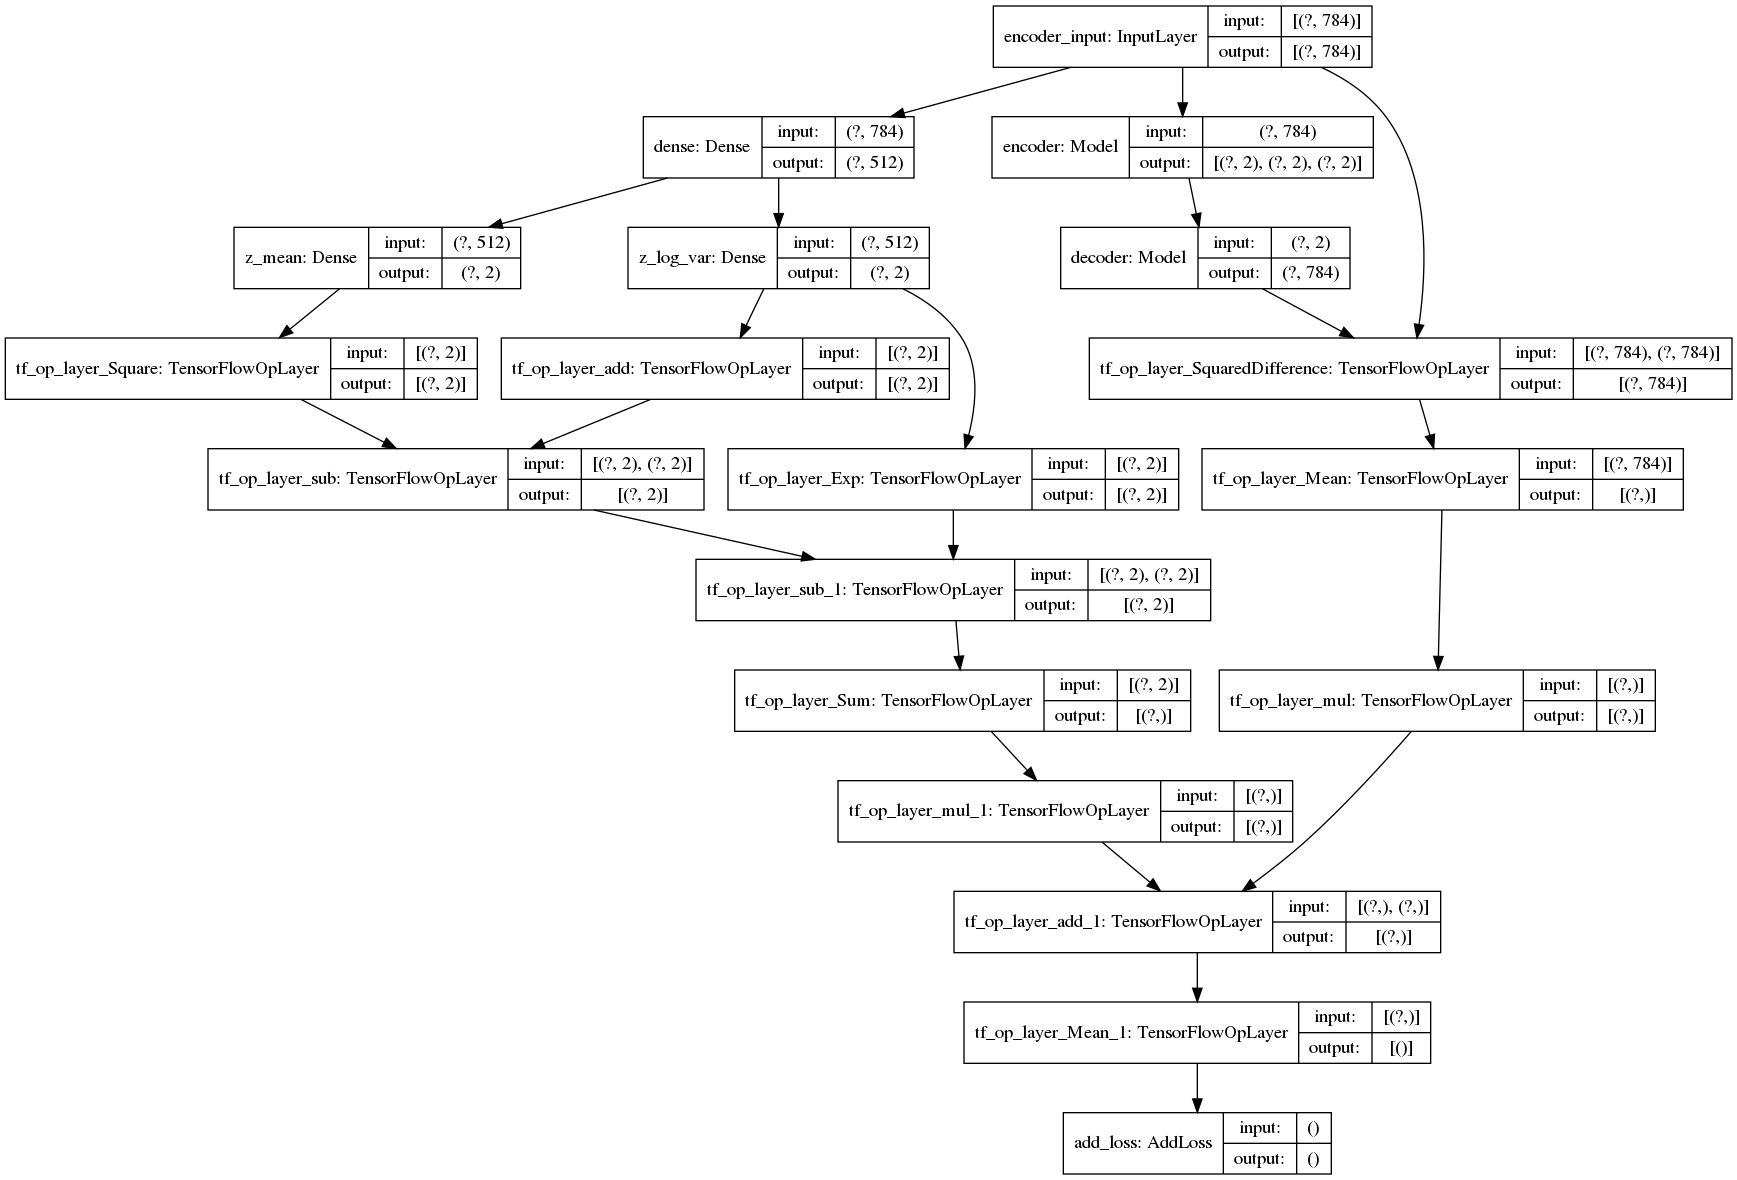

In [24]:
plot_model(vae, to_file='../figures/vae_mlp.png', show_shapes=True)

In [26]:
save_path = '../models/vae_mlp'

In [27]:
# vae.fit(x_train,
#         epochs=epochs,
#         batch_size=batch_size,
#         validation_data=(x_test, None))

# vae.save_weights(save_path)

In [28]:
vae.load_weights(save_path)

In [29]:
y_pred = vae.predict(x_test)

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
def draw_figure(i):
    
    fig, ax_arr = plt.subplots(1, 2)
    
    imgs = [x_test[i].reshape(28, 28), y_pred[i].reshape(28, 28)]
    labels = ['input', 'output']
    for idx, img in enumerate(imgs):
        ax = ax_arr[idx]
        ax.imshow(img)
        ax.set_title(labels[idx])
        ax.axis('off')

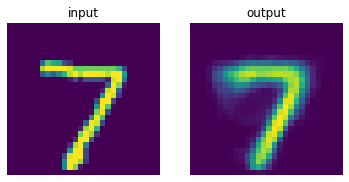

In [32]:
draw_figure(0)

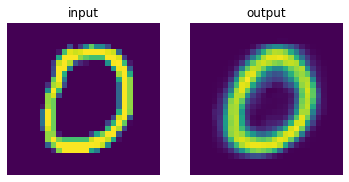

In [33]:
draw_figure(10)

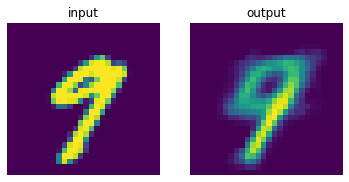

In [34]:
draw_figure(20)

## plot results

In [ ]:
import pandas as pd

In [39]:
xmin = ymin = -4
xmax = ymax = +4

In [41]:
mean_fig_name = "../figures/vae_mlp_mean.png"
digit_latent_fig_name = "../figures/vae_mlp_digit_latent.png"

In [47]:
mu, sig, z = encoder.predict(x_test, batch_size=batch_size)

In [63]:
mu_samp = mu[0::10]
y_test_samp = y_test[0::10]

In [106]:
labels = np.unique(y_test_samp)
colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))
color_dict = {
    l: colors[i] for i, l in enumerate(labels)
}

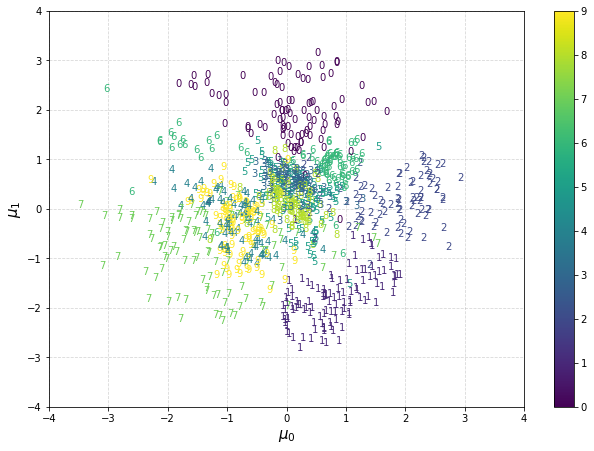

In [113]:
fig, ax = plt.subplots(1, 1)
ax.grid(linestyle='--', alpha=0.5)

fig.gca()
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])

cmap = ax.scatter(mu_samp[:, 0], mu_samp[:, 1], marker="")
cmap.set_clim(0, 9)
for i, digit in enumerate(y_test_samp):
    ax.annotate(digit, (mu_samp[i, 0], mu_samp[i, 1]), color=color_dict[digit])
    
ax.set_xlabel('$\mu_0$', fontsize=15)
ax.set_ylabel('$\mu_1$', fontsize=15)

fig.subplots_adjust(right=1.5, top=1.5)
fig.colorbar(cmap)

fig.savefig(mean_fig_name)

In [114]:
# display a 30x30 2D manifold of digits
n = 30
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

In [116]:
# linearly spaced coordinates corresponding to the 2D plot
# of digit classes in the latent space
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)[::-1]

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

In [138]:
sample_range_x

array([-4. , -3.7, -3.4, -3.2, -2.9, -2.6, -2.3, -2.1, -1.8, -1.5, -1.2,
       -1. , -0.7, -0.4, -0.1,  0.1,  0.4,  0.7,  1. ,  1.2,  1.5,  1.8,
        2.1,  2.3,  2.6,  2.9,  3.2,  3.4,  3.7,  4. ])

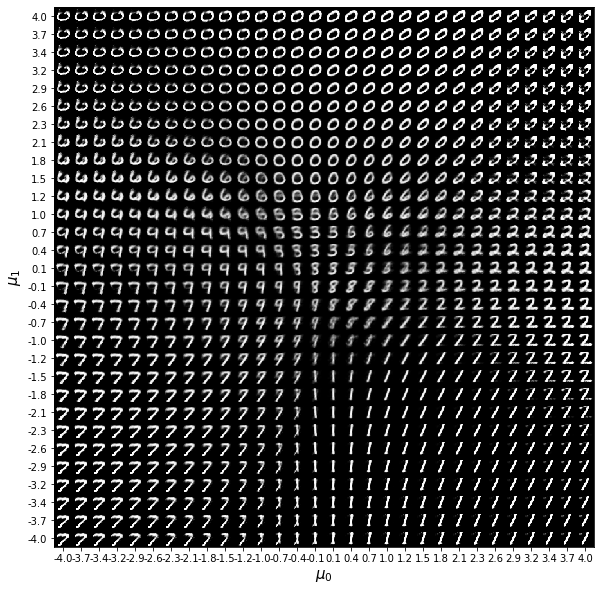

In [142]:
fig, ax = plt.subplots()

start_range = digit_size // 2
end_range = n * digit_size + start_range + 1
pixel_range = np.arange(start_range, end_range, digit_size)

sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)

ax.set_xticks(pixel_range)
ax.set_yticks(pixel_range)
ax.set_xticklabels(sample_range_x)
ax.set_yticklabels(sample_range_y)

ax.set_xlabel("$\mu_0$", fontsize=15)
ax.set_ylabel("$\mu_1$", fontsize=15)

ax.imshow(figure, cmap='Greys_r')
fig.subplots_adjust(right=2, top=2)

plt.savefig(digit_latent_fig_name)